In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


58889256/58889256 [==============================] - 3s 0us/step
Found 5732 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
1/1 [==============================] - 1s 1s/step
Test accuracy: 0.935163996948894

Classification Report:
               precision    recall  f1-score   support

      glioma       0.89      0.87      0.88       300
  meningioma       0.88      0.87      0.87       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.96      0.98      0.97       300

    accuracy                           0.94      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.94      0.93      1311


Confusion Matrix:
 [[262  34   0   4]
 [ 29 266   2   9]
 [  0   0 405   0]
 [  2   4   1 293]]


Class: glioma
TP: 262, TN: 980, FP: 31, FN: 38
Precision: 0.89, Sensitivity: 0.87, Specificity: 0.97, F1 Score: 0.88

Class: melingioma
TP: 266, TN: 967, FP: 38, FN: 40
Precision: 0.88, Sensitivity: 0.87, Spec

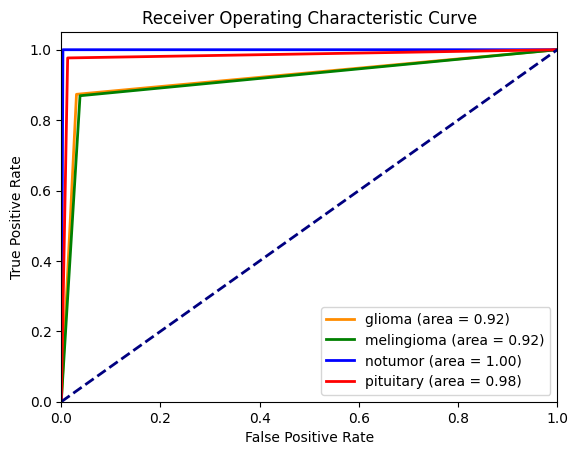

In [2]:
# Import the required libraries
import keras
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Load the VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False)

# Define a function to extract features using the VGG16 model
def extract_features(model, generator):
    features = []
    labels = []
    steps = len(generator)
    for i in range(steps):
        inputs_batch, labels_batch = next(generator)
        features_batch = model.predict(inputs_batch)
        features.append(features_batch)
        labels.append(labels_batch)
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels


# Load the brain tumor images and preprocess them
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_directory = '/content/drive/MyDrive/DSAI_Project/Brain_tumor_classification/Training'
test_directory = '/content/drive/MyDrive/DSAI_Project/Brain_tumor_classification/Testing'


train_generator = train_datagen.flow_from_directory(
        train_directory,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        test_directory,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

# Extract features from the train and test data using VGG16
train_features, train_labels = extract_features(vgg_model, train_generator)
test_features, test_labels = extract_features(vgg_model, test_generator)

# Flatten the features
train_features = np.reshape(train_features, (train_features.shape[0], -1))
test_features = np.reshape(test_features, (test_features.shape[0], -1))

# Train an SVM classifier on the extracted features
svm_model = SVC(kernel='linear', C=0.1)


# Create an SVM classifier instance
svm_classifier = SVC(kernel='linear')


# Train the SVM classifier with multiple epochs
train_labels_orig = np.argmax(train_labels, axis=1)
svm_classifier.fit(train_features, train_labels_orig)

# Evaluate the performance of the SVM classifier on the test data
test_predictions = svm_classifier.predict(test_features)
test_score = svm_classifier.score(test_features, np.argmax(test_labels, axis=1))
print('Test accuracy:', test_score)

# Compute performance metrics
target_names = list(test_generator.class_indices.keys())
print('\nClassification Report:\n', classification_report(np.argmax(test_labels, axis=1), test_predictions, target_names=target_names))
print('\nConfusion Matrix:\n', confusion_matrix(np.argmax(test_labels, axis=1), test_predictions))
print('\n')


# Calculate evaluation metrics for each class
target_names = ['glioma', 'melingioma', 'notumor', 'pituitary']
#test_labels = np.argmax(test_labels, axis=1)

for i, target_name in enumerate(target_names):
    tp = np.sum((test_predictions == i) & (test_labels[:, i] == 1))
    tn = np.sum((test_predictions != i) & (test_labels[:, i] != 1))
    fp = np.sum((test_predictions == i) & (test_labels[:, i] != 1))
    fn = np.sum((test_predictions != i) & (test_labels[:, i] == 1))
    precision = precision_score(test_labels[:, i], test_predictions == i, zero_division=0)
    sensitivity = recall_score(test_labels[:, i], test_predictions == i, zero_division=0)
    specificity = tn / (tn + fp)
    f1 = f1_score(test_labels[:, i], test_predictions == i, zero_division=0)
    print(f"Class: {target_name}")
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print(f"Precision: {precision:.2f}, Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}, F1 Score: {f1:.2f}\n")

test_labels = np.argmax(test_labels, axis=1)   
test_labels_onehot = np.zeros((test_labels.size, test_labels.max()+1))
test_labels_onehot[np.arange(test_labels.size),test_labels] = 1
test_predictions_onehot = np.zeros((test_predictions.size, test_predictions.max()+1))
test_predictions_onehot[np.arange(test_predictions.size),test_predictions] = 1

# Plot the ROC-AUC curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_labels_onehot[:, i], test_predictions_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
plt.plot(fpr[0], tpr[0], color='darkorange', lw=2, label=f'{target_names[0]} (area = {roc_auc[0]:.2f})')
plt.plot(fpr[1], tpr[1], color='green', lw=2, label=f'{target_names[1]} (area = {roc_auc[1]:.2f})')
plt.plot(fpr[2], tpr[2], color='blue', lw=2, label=f'{target_names[2]} (area = {roc_auc[2]:.2f})')
plt.plot(fpr[3], tpr[3], color='red', lw=2, label=f'{target_names[3]} (area = {roc_auc[3]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()
